In [273]:
import csv
from collections import defaultdict
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib

# Load data

In [274]:
# load data

class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.asd = data[8]
        self.premature = data[9]
        self.gestation = 40 if data[10]=='' else int(data[10])
        self.verbal = int(data[11])
        self.sleep = data[12]
        self.hearing = data[13]
        self.vision = data[14]
        self.noise = data[15]
        self.motor = data[16]
        self.metabolic = data[17]
        self.gi = data[18]
        self.infections = data[19]
        self.seizures = data[20]
        self.SCQ = None
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
children = []
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for line in reader:
        child = Child(line)
        fam_to_children[child.family].append(child)
        children.append(child)
        
children_f = [x for x in children if x.sex=='female']
children_m = [x for x in children if x.sex=='male']

In [275]:
# Figure out what's in each column

# asd: yes/no
# premature: yes/no/missing=''
# sleep: yes/no/missing=''
# hearing: yes_hearingaids/yes_other/no/missing=''
# vision: yes/yes_other/no
# noise: yes_severe/yes_moderate/yes_mild/yes_other/yes_prefers/no/missing=''
# motor: yes/yes_some/no
# metabolic: yes/no/missing=''
# gi: yes/no/''
# infections: yes_constantly/yes_often/yes_slightly/no/missing=''
# seizures: yes/no/missing=''
# gestation: 23-40
# verbal: 1-10

print(set([x.seizures for x in children]))

{'', 'no', 'yes'}


In [276]:
print(children[0].sex)

male


# Now we compare "correlation" between attributes

In [326]:
# This is how we compare "correlation" for different combinations of attributes. Since some of our attributes are
# categorical, some are binary, and some are discrete, we use different tests.

cat_attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'premature', 'hearing', 'vision', 'metabolic', \
             'infections', 'seizures', 'verbal']
#disc_attrs = ['gestation']
disc_attrs = []

attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'verbal', 'infections', 'hearing', 'seizures', 'vision', \
         'metabolic', 'premature']
attr_to_index = dict([(x, i) for i, x in enumerate(attrs)])

X = np.ones((len(attrs), len(attrs)))
X_f = np.ones((len(attrs), len(attrs)))
X_m = np.ones((len(attrs), len(attrs)))


# use all responses in chi2
def compare_cat_full(attr_i, attr_j, children):
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    options_j = [y for y in set([getattr(x, attr_j) for x in children]) if y!='']
    
    c = np.zeros((len(options_i), len(options_j)))
    for k, opt_i in enumerate(options_i):
        for l, opt_j in enumerate(options_j):
            c[k, l] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, attr_j)==opt_j])
    return stats.chi2_contingency(c)[1]
    
# binarize categorical attributes into "no" and everything else
def compare_cat_as_bin(attr_i, attr_j, children):
    c = [[len([x for x in children if getattr(x, attr_i)=='no' and getattr(x, attr_j)=='no']),
         len([x for x in children if getattr(x, attr_i)=='no' and getattr(x, attr_j)!='no'])],
         [len([x for x in children if getattr(x, attr_i)!='no' and getattr(x, attr_j)=='no']),
         len([x for x in children if getattr(x, attr_i)!='no' and getattr(x, attr_j) !='no'])]]
    return stats.chi2_contingency(c)[1]
    

# categorical vs categorical with chi-squared test
num_tests = 0
for attr_i, attr_j in combinations(cat_attrs, r=2):
    p = compare_cat_full(attr_i, attr_j, children)
    #p = compare_cat_as_bin(attr_i, attr_j, children)
    X[attr_to_index[attr_i], attr_to_index[attr_j]] = p
    X[attr_to_index[attr_j], attr_to_index[attr_i]] = p
    
    p_f = compare_cat_full(attr_i, attr_j, children_f)
    #p_f = compare_cat_as_bin(attr_i, attr_j, children_f)
    X_f[attr_to_index[attr_i], attr_to_index[attr_j]] = p_f
    X_f[attr_to_index[attr_j], attr_to_index[attr_i]] = p_f
    
    p_m = compare_cat_full(attr_i, attr_j, children_m)
    #p_m = compare_cat_as_bin(attr_i, attr_j, children_m)
    X_m[attr_to_index[attr_i], attr_to_index[attr_j]] = p_m
    X_m[attr_to_index[attr_j], attr_to_index[attr_i]] = p_m
    
    num_tests += 1
    
for attr_i in cat_attrs:
    X[attr_to_index[attr_i], attr_to_index[attr_i]] = compare_cat_full(attr_i, attr_i, children)
        
# categorical vs discrete with Kruskal-Wallis H-test
# we're treating our two discrete variables as continuous because the spread is large enough (>7)
for attr_i in cat_attrs:
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    
    for attr_j in disc_attrs:
        samples = []
        samples_f = []
        samples_m = []
        for opt_i in options_i:
            samples.append([getattr(x, attr_j) for x in children if getattr(x, attr_i)==opt_i])
            samples_f.append([getattr(x, attr_j) for x in children if getattr(x, attr_i)==opt_i and x.sex=='female'])
            samples_m.append([getattr(x, attr_j) for x in children if getattr(x, attr_i)==opt_i and x.sex=='male'])
        X[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.kruskal(*samples)[1]
        X[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.kruskal(*samples)[1]
        X_m[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.kruskal(*samples_m)[1]
        X_m[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.kruskal(*samples_m)[1]
        X_f[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.kruskal(*samples_f)[1]
        X_f[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.kruskal(*samples_f)[1]
        
# discrete vs discrete with pearson r
# we're treating our two discrete variables as continuous because the spread is large enough (>7)
for attr_i, attr_j in combinations(disc_attrs, r=2): 
    y = [getattr(x, attr_i) for x in children]
    y_f = [getattr(x, attr_i) for x in children if x.sex=='female']
    y_m = [getattr(x, attr_i) for x in children if x.sex=='male']

    z = [getattr(x, attr_j) for x in children]
    z_f = [getattr(x, attr_j) for x in children if x.sex=='female']
    z_m = [getattr(x, attr_j) for x in children if x.sex=='male']
        
    X[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.pearsonr(y, z)[1]
    X[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.pearsonr(y, z)[1]
    X_f[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.pearsonr(y_f, z_f)[1]
    X_f[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.pearsonr(y_f, z_f)[1]
    X_m[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.pearsonr(y_m, z_m)[1]
    X_m[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.pearsonr(y_m, z_m)[1]
    
for attr_i in disc_attrs:
    y = [getattr(x, attr_i) for x in children]
    X[attr_to_index[attr_i], attr_to_index[attr_i]] = stats.pearsonr(y, y)[1]

In [327]:
print(X[0, :])

[0.00000000e+000 2.26818544e-065 2.33881228e-057 1.01258151e-031
 4.66081699e-028 6.21393326e-104 4.50191758e-015 3.05040018e-001
 8.86336253e-004 8.94155768e-003 4.28036159e-006 1.68125871e-002]


/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_14494/573613466.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.clip(-np.log10(X*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))


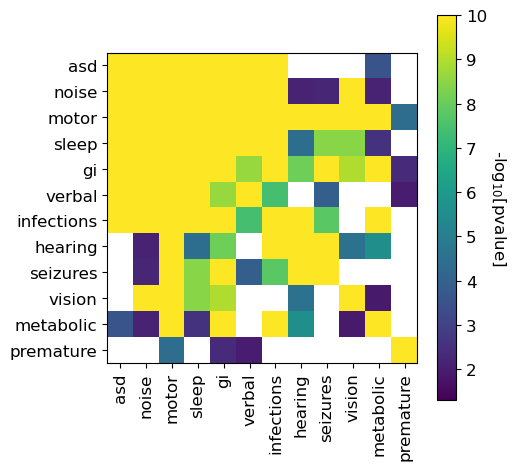

In [328]:
# Plot "correlation" between all pairs of attributes

X[X>0.05/num_tests] = np.nan

plt.figure(figsize=(5, 5))

plt.imshow(np.clip(-np.log10(X*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(len(attrs)), attrs, rotation=90, fontsize=12)
plt.yticks(range(len(attrs)), attrs, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)

plt.show()

/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_14494/577986888.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.clip(-np.log10(X), 0, 20))


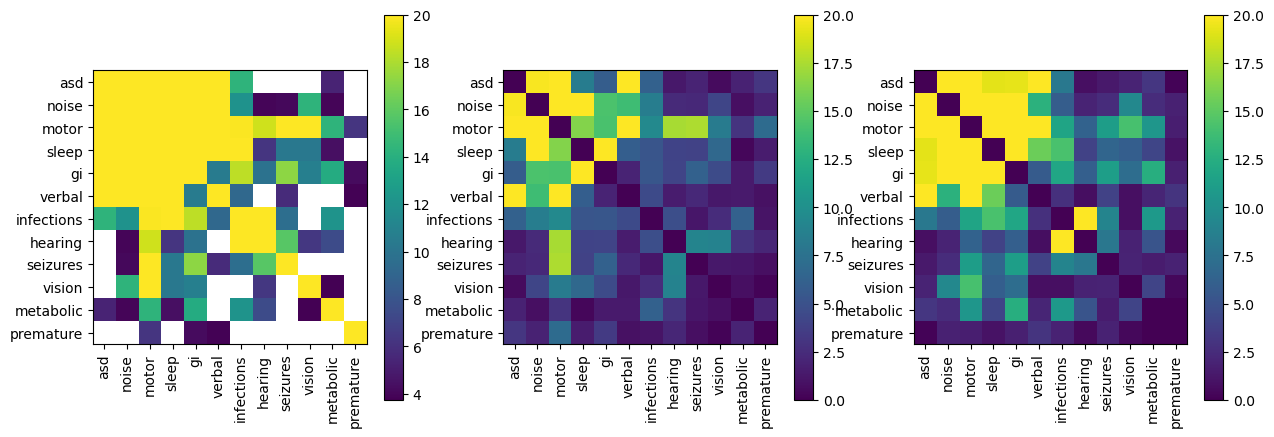

In [280]:
# Plot "correlation" between all pairs of attributes

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.clip(-np.log10(X), 0, 20))
plt.colorbar()
plt.xticks(range(len(attrs)), attrs, rotation=90)
plt.yticks(range(len(attrs)), attrs)

plt.subplot(1, 3, 2)
plt.imshow(np.clip(-np.log10(X_f), 0, 20))
plt.colorbar()
plt.xticks(range(len(attrs)), attrs, rotation=90)
plt.yticks(range(len(attrs)), attrs)

plt.subplot(1, 3, 3)
plt.imshow(np.clip(-np.log10(X_m), 0, 20))
plt.colorbar()
plt.xticks(range(len(attrs)), attrs, rotation=90)
plt.yticks(range(len(attrs)), attrs)
plt.show()

['premature']
['metabolic']


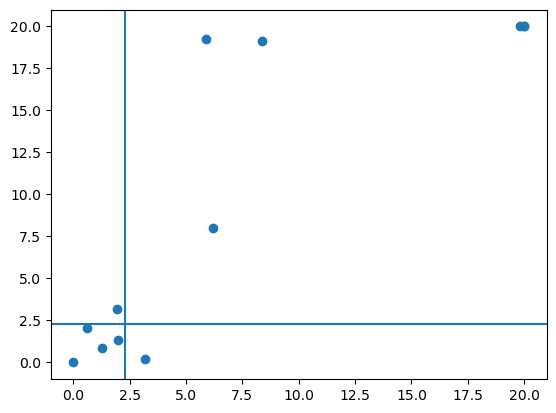

In [250]:
plt.scatter(np.clip(-np.log10(X_f[0, :]), 0, 20).flatten(), np.clip(-np.log10(X_m[0, :]), 0, 20).flatten())
plt.axhline(-np.log10(0.05/10))
plt.axvline(-np.log10(0.05/10))

print([attrs[i] for i in np.where((X_f[0, :]<0.05/10) & (X_m[0, :]>0.05/10))[0]])
print([attrs[i] for i in np.where((X_f[0, :]>0.05/10) & (X_m[0, :]<0.05/10))[0]])
plt.show()

# Focus on correlation between autism status and each attribute

We might worry that family structure is distorting the correlations found above. So to take family structure out of
the equation, we'll try running a permutation test where we permute ASD status within families and then compare
the correlations we get with permuted data to the correlations we see in our actual data.

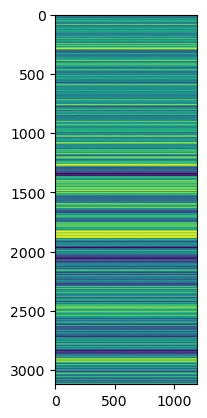

In [252]:
# First, we permute ASD status within families a bunch of times (12,000X)
# asd=1, nt=0

num_trials = 1200
permuted_asd_status = np.zeros((len(children), num_trials))
child_to_index = dict([(x.id, i) for i, x in enumerate(children)])

permuted_asd_status_f = np.zeros((len(children_f), num_trials))
child_to_index_f = dict([(x.id, i) for i, x in enumerate(children_f)])
permuted_asd_status_m = np.zeros((len(children_m), num_trials))
child_to_index_m = dict([(x.id, i) for i, x in enumerate(children_m)])

for fam, fam_children in fam_to_children.items():
    asd_status = [1 if child.asd=='yes' else 0 for child in fam_children]
    permuted_asd_status[[child_to_index[child.id] for child in fam_children], :] = np.array([random.sample(asd_status, k=len(asd_status)) for _ in range(num_trials)]).T

    asd_status = [1 if child.asd=='yes' else 0 for child in fam_children if child.sex=='female']
    permuted_asd_status_f[[child_to_index_f[child.id] for child in fam_children if child.sex=='female'], :] = np.array([random.sample(asd_status, k=len(asd_status)) for _ in range(num_trials)]).T

    asd_status = [1 if child.asd=='yes' else 0 for child in fam_children if child.sex=='male']
    permuted_asd_status_m[[child_to_index_m[child.id] for child in fam_children if child.sex=='male'], :] = np.array([random.sample(asd_status, k=len(asd_status)) for _ in range(num_trials)]).T

plt.imshow(permuted_asd_status)


In [329]:
# Now we compare the correlations we get when we look at the permuted data to the correlations we get when we
# look at the real data. This requires a lot of chi-squared tests so it takes a while to run.

# takes time to run due to permutations
permutation_pvalues = np.ones((len(attrs), 3))
chi2_pvalues = np.ones((len(attrs), 3))

is_aut = np.array([x.asd=='yes' for x in children])
is_aut_f = np.array([x.asd=='yes' for x in children_f])
is_aut_m = np.array([x.asd=='yes' for x in children_m])

# categorical
for i, attr_i in enumerate(cat_attrs):
    print(attr_i, end=' ')
    is_attr = np.array([getattr(x, attr_i)!='no' for x in children])
    is_attr_f = np.array([getattr(x, attr_i)!='no' for x in children_f])
    is_attr_m = np.array([getattr(x, attr_i)!='no' for x in children_m])
    
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    options_j = ['yes', 'no']
            
    c = np.zeros((len(options_i), len(options_j)))
    for k, opt_i in enumerate(options_i):
        c[k, 0] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='yes'])
        c[k, 1] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='no'])
    #c = [[np.sum(is_aut & is_attr), np.sum(~is_aut & is_attr)],
    #     [np.sum(is_aut & ~is_attr), np.sum(~is_aut & ~is_attr)]]
    s, p = stats.chi2_contingency(c)[:2]
    chi2_pvalues[attr_to_index[attr_i], 0] = p
    
    #for k, opt_i in enumerate(options_i):
    #    c[k, 0] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='yes' and x.sex=='female'])
    #    c[k, 1] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='no' and x.sex=='female'])
    #c = [[np.sum(is_aut_f & is_attr_f), np.sum(~is_aut_f & is_attr_f)],
    #     [np.sum(is_aut_f & ~is_attr_f), np.sum(~is_aut_f & ~is_attr_f)]]
    #s_f, p_f = stats.chi2_contingency(c)[:2]
    #chi2_pvalues[i, 1] = p_f
    
    #for k, opt_i in enumerate(options_i):
    #    c[k, 0] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='yes' and x.sex=='male'])
    #    c[k, 1] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='no' and x.sex=='male'])
    #c = [[np.sum(is_aut_m & is_attr_m), np.sum(~is_aut_m & is_attr_m)],
    #     [np.sum(is_aut_m & ~is_attr_m), np.sum(~is_aut_m & ~is_attr_m)]]
    #s_m, p_m = stats.chi2_contingency(c)[:2]
    #chi2_pvalues[i, 2] = p_m
    
    # estimate pvalues by permuting asd status within families
    num_over, num_over_f, num_over_m = 0, 0, 0
    for trial in range(num_trials):
        for k, opt_i in enumerate(options_i):
            #c = [[np.sum((permuted_asd_status[:, trial]==1) & is_attr), 
            #      np.sum((permuted_asd_status[:, trial]==0) & is_attr)],
            #     [np.sum((permuted_asd_status[:, trial]==1) & ~is_attr), 
            #      np.sum((permuted_asd_status[:, trial]==0) & ~is_attr)]]
            c[k, 0] = len([x for j, x in enumerate(children) if getattr(x, attr_i)==opt_i and permuted_asd_status[j, trial]==1])
            c[k, 1] = len([x for j, x in enumerate(children) if getattr(x, attr_i)==opt_i and permuted_asd_status[j, trial]==0])
        num_over += int(np.abs(stats.chi2_contingency(c)[0])>=np.abs(s))
        
        #for k, opt_i in enumerate(options_i):
        #    c = [[np.sum((permuted_asd_status_f[:, trial]==1) & is_attr_f), 
        #          np.sum((permuted_asd_status_f[:, trial]==0) & is_attr_f)],
        #         [np.sum((permuted_asd_status_f[:, trial]==1) & ~is_attr_f), 
        #          np.sum((permuted_asd_status_f[:, trial]==0) & ~is_attr_f)]]
        #    #c[k, 0] = len([x for j, x in enumerate(children_f) if getattr(x, attr_i)==opt_i and permuted_asd_status_f[j, trial]==1])
        #    #c[k, 1] = len([x for j, x in enumerate(children_f) if getattr(x, attr_i)==opt_i and permuted_asd_status_f[j, trial]==0])
        #num_over_f += int(stats.chi2_contingency(c)[0]>=s_f)
        #
        #for k, opt_i in enumerate(options_i):
        #    c = [[np.sum((permuted_asd_status_m[:, trial]==1) & is_attr_m), 
        #          np.sum((permuted_asd_status_m[:, trial]==0) & is_attr_m)],
        #         [np.sum((permuted_asd_status_m[:, trial]==1) & ~is_attr_m), 
        #          np.sum((permuted_asd_status_m[:, trial]==0) & ~is_attr_m)]]
        #    #c[k, 0] = len([x for j, x in enumerate(children_m) if getattr(x, attr_i)==opt_i and permuted_asd_status_m[j, trial]==1])
        #    #c[k, 1] = len([x for j, x in enumerate(children_m) if getattr(x, attr_i)==opt_i and permuted_asd_status_m[j, trial]==0])
        #num_over_m += int(stats.chi2_contingency(c)[0]>=s_m)
    permutation_pvalues[attr_to_index[attr_i], 0] = num_over/num_trials
    permutation_pvalues[attr_to_index[attr_i], 1] = num_over_f/num_trials
    permutation_pvalues[attr_to_index[attr_i], 2] = num_over_m/num_trials


asd noise motor sleep gi premature hearing vision metabolic infections seizures verbal 

In [330]:
# Same as above for the discrete attributes.

# discrete
for i, attr_i in enumerate(disc_attrs):
    samples = [[getattr(x, attr_i) for x in children if getattr(x, 'asd')=='yes'],
              [getattr(x, attr_i) for x in children if getattr(x, 'asd')=='no']] 
    s, p = stats.kruskal(*samples)[:2]
    chi2_pvalues[i+len(cat_attrs)-1, 0] = p
    
    samples = [[getattr(x, attr_i) for x in children_f if getattr(x, 'asd')=='yes'],
              [getattr(x, attr_i) for x in children_f if getattr(x, 'asd')=='no']] 
    s_f, p_f = stats.kruskal(*samples)[:2]
    chi2_pvalues[i+len(cat_attrs)-1, 1] = p_f
    
    samples = [[getattr(x, attr_i) for x in children_m if getattr(x, 'asd')=='yes'],
              [getattr(x, attr_i) for x in children_m if getattr(x, 'asd')=='no']] 
    s_m, p_m = stats.kruskal(*samples)[:2]
    chi2_pvalues[i+len(cat_attrs)-1, 2] = p_m
    
    num_over, num_over_f, num_over_m = 0, 0, 0
    for trial in range(num_trials):
        perm_samples = [[getattr(x, attr_i) for j, x in enumerate(children) if permuted_asd_status[j, trial]==1],
                        [getattr(x, attr_i) for j, x in enumerate(children) if permuted_asd_status[j, trial]==0]] 
        num_over += int(stats.kruskal(*perm_samples)[0]>=s)
        
        perm_samples = [[getattr(x, attr_i) for j, x in enumerate(children_f) if permuted_asd_status_f[j, trial]==1],
                        [getattr(x, attr_i) for j, x in enumerate(children_f) if permuted_asd_status_f[j, trial]==0]] 
        num_over_f += int(stats.kruskal(*perm_samples)[0]>=s_f)
        
        perm_samples = [[getattr(x, attr_i) for j, x in enumerate(children_m) if permuted_asd_status_m[j, trial]==1],
                        [getattr(x, attr_i) for j, x in enumerate(children_m) if permuted_asd_status_m[j, trial]==0]] 
        num_over_m += int(stats.kruskal(*perm_samples)[0]>=s_m)
    permutation_pvalues[attr_to_index[attr_i], 0] = num_over/num_trials
    permutation_pvalues[attr_to_index[attr_i], 1] = num_over_f/num_trials
    permutation_pvalues[attr_to_index[attr_i], 2] = num_over_m/num_trials
        

In [331]:
print(X[:, 0])
print(chi2_pvalues[:, 0])

[0.00000000e+000 2.26818544e-065 2.33881228e-057 1.01258151e-031
 4.66081699e-028 6.21393326e-104 4.50191758e-015             nan
             nan             nan 4.28036159e-006             nan]
[0.00000000e+000 2.26818544e-065 2.33881228e-057 1.01258151e-031
 4.66081699e-028 6.21393326e-104 4.50191758e-015 3.05040018e-001
 8.86336253e-004 8.94155768e-003 4.28036159e-006 1.68125871e-002]


In [333]:
print('attr\t\tchi\t\tperm\tf\tm')
for i, a in enumerate(attrs):
    print(a[:6] + '\t', '%0.3e' % np.clip(chi2_pvalues[i, 0]*11, 0, 1), 
          '%0.3f' % np.clip(11*permutation_pvalues[i, 0], 0, 1),
          '%0.3f' % np.clip(11*permutation_pvalues[i, 1], 0, 1),
          '%0.3f' % np.clip(11*permutation_pvalues[i, 2], 0, 1), sep='\t')


attr		chi		perm	f	m
asd		0.000e+00	0.000	0.000	0.000
noise		2.495e-64	0.000	0.000	0.000
motor		2.573e-56	0.000	0.000	0.000
sleep		1.114e-30	0.000	0.000	0.000
gi		5.127e-27	0.000	0.000	0.000
verbal		6.835e-103	0.000	0.000	0.000
infect		4.952e-14	0.000	0.000	0.000
hearin		1.000e+00	1.000	0.000	0.000
seizur		9.750e-03	0.000	0.000	0.000
vision		9.836e-02	1.000	0.000	0.000
metabo		4.708e-05	0.110	0.000	0.000
premat		1.849e-01	0.247	0.000	0.000


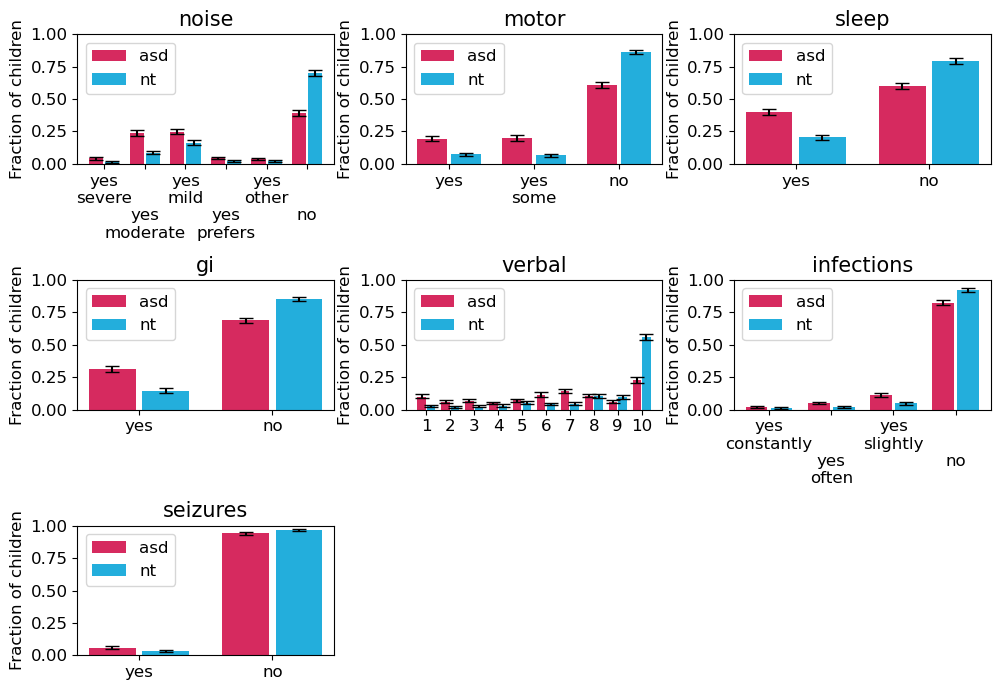

In [320]:
colors = ['#d62a5f', '#23aedc', '#d0bf4d', '#2d3594', '#d62a5f']

pvalues = permutation_pvalues[:, 0]

# plot results
plt.figure(figsize=(10, 7))

def plotbar(r, total, color, offset=0, label=None):
    p = r/total
    lb, ub = sm.stats.proportion_confint(r, total, alpha=0.05, method='agresti_coull')
    plt.bar(np.arange(len(r))+offset, p, width=0.35, label=label, color=color)
    plt.errorbar(np.arange(len(r))+offset, p, 
                 yerr=[p-lb, ub-p], 
                 color='black', linestyle='', capsize=5)

subplot_num = 1

ordered_responses = ['yes', 'yes_hearingaids', 'yes_severe', 'yes_constantly', 'yes_often', 'yes_moderate', 'yes_mild', 'yes_prefers', 'yes_other', 'yes_some', 'yes_slightly', 'no'] + list(np.arange(11))

# categorical
for i, attr_i in enumerate(attrs[1:]):
    if pvalues[i+1]*12 < 0.05:
        options_i = sorted([y for y in set([getattr(x, attr_i) for x in children]) if y!=''], key=lambda x: ordered_responses.index(x))
        options_j = ['yes', 'no']

        c = np.zeros((len(options_i), len(options_j)))
        for k, opt_i in enumerate(options_i):
            c[k, 0] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='yes'])
            c[k, 1] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='no'])

        plt.subplot(3, 3, subplot_num)
        subplot_num += 1
        plotbar(c[:, 0], np.sum(c[:, 0]), colors[0], label='asd')
        plotbar(c[:, 1], np.sum(c[:, 1]), colors[1], offset=0.4, label='nt')

        #plt.bar(np.arange(len(options_i)), c[:, 0], width=0.2, label=options_j[0])
        #plt.bar(np.arange(len(options_i))+0.3, c[:, 1], width=0.2, label=options_j[1])
        #plt.title('%s (pvalue%s)' % (attr_i, '<0.001' if 12*pvalues[i]<0.001 else ('=%0.2f' % np.clip(12*pvalues[i], 0, 1))),
        #         fontsize=15)
        plt.title(attr_i, fontsize=15)
        if np.any([len(str(x))>10 for x in options_i]):
            plt.xticks(np.arange(len(options_i))+0.2, [('' if i%2==0 else '\n\n') + str(x).replace('_', '\n') for i, x in enumerate(options_i)], fontsize=12)
        else:
            plt.xticks(np.arange(len(options_i))+0.2, [str(x).replace('_', '\n') for x in options_i], fontsize=12)
        plt.ylim([0, 1])
        plt.yticks(fontsize=12)
        plt.ylabel('Fraction of children', fontsize=12)
        plt.legend(fontsize=12)
    

# discrete
for i, attr_i in enumerate(disc_attrs):
    samples = [[getattr(x, attr_i) for x in children if getattr(x, 'asd')=='yes'],
               [getattr(x, attr_i) for x in children if getattr(x, 'asd')=='no']]
        
    plt.subplot(3, 4, i+len(cat_attrs))
    plt.hist(samples, density=True)
    plt.title('%s (pvalue%s)' % (attr_i, '<0.001' if 12*pvalues[i+len(cat_attrs)-1]<0.001 else ('=%0.2f' % np.clip(12*pvalues[i+len(cat_attrs)-1], 0, 1))))
    
plt.tight_layout()
plt.show()

# Pull in SCQ

In [281]:
child_id_to_index = dict([(child.id, i) for i, child in enumerate(children)])
with open('../data/kidsFirstAdminExport_09-20-2022_SCQ.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    scq_header = next(reader)[20:60]
    next(reader)
    next(reader)
    next(reader)
    for line in reader:
        child_id = line[0]
        if child_id in child_id_to_index:
            children[child_id_to_index[child_id]].SCQ = [None if x=='' else x=='1' for x in line[20:60]]

children_scq = [child for child in children if child.SCQ is not None]

In [286]:
X_scq = np.ones((len(attrs), len(attrs)+40))
X_scq[:len(attrs), :len(attrs)] = X

# categorical vs categorical with chi-squared test
#for i, j in combinations(np.arange(40), r=2):
#    options_i = [y for y in set([x.SCQ[i] for x in children_scq])]
#    options_j = [y for y in set([x.SCQ[j] for x in children_scq])]
#    
#    c = np.zeros((len(options_i), len(options_j)))
#    for k, opt_i in enumerate(options_i):
#        for l, opt_j in enumerate(options_j):
#            c[k, l] = len([x for x in children_scq if x.SCQ[i]==opt_i and x.SCQ[j]==opt_j])
#    p = stats.chi2_contingency(c)[1]
#    X_scq[len(attrs)+i, len(attrs)+j] = p
#    X_scq[len(attrs)+j, len(attrs)+i] = p
    

for i in np.arange(40):
    for attr_j in attrs:
        options_j = [y for y in set([getattr(x, attr_j) for x in children_scq]) if y!='']
    
        c = np.zeros((len(options_i), len(options_j)))
        for k, opt_i in enumerate(options_i):
            for l, opt_j in enumerate(options_j):
                c[k, l] = len([x for x in children_scq if x.SCQ[i]==opt_i and getattr(x, attr_j)==opt_j])
        p = stats.chi2_contingency(c)[1]
        #X_scq[len(attrs)+i, attr_to_index[attr_j]] = p
        X_scq[attr_to_index[attr_j], len(attrs)+i] = p

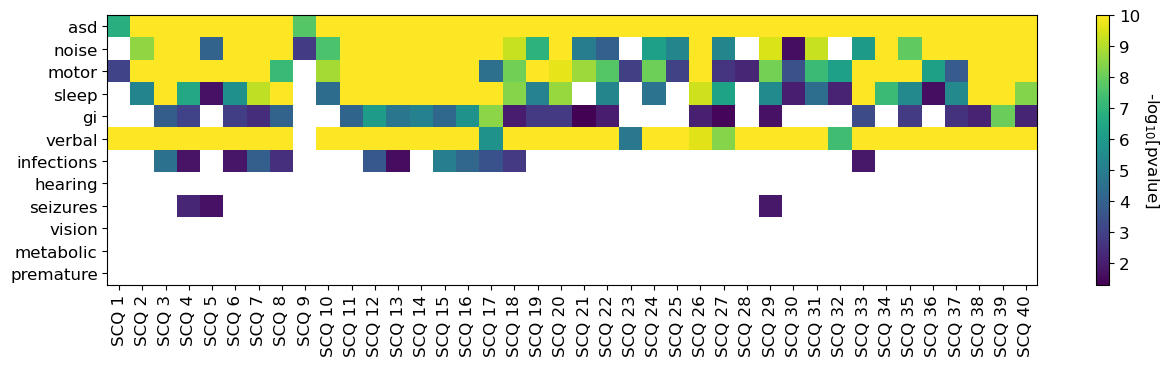

In [322]:
# Plot "correlation" between all pairs of attributes
plt.figure(figsize=(15, 3.5))

num_tests = (12*40)
X_scq[X_scq>0.05/num_tests] = np.nan

plt.imshow(np.clip(-np.log10(X_scq[:, len(attrs):]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05), aspect='auto')
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(np.arange(40), ['SCQ %d' % (i+1) for i in range(40)], rotation=90, fontsize=12)
plt.yticks(range(len(attrs)), attrs, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
#plt.axvline(len(attrs)-0.5, color='black', linestyle='--')

plt.show()